In [1]:
import pandas as pd 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def preprocess(df):
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Embarked'] = df['Embarked'].fillna('Unknown')
    df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    df['Embarked'] = df['Embarked'].map({'S':0, 'C':1, 'Q':2, 'Unknown':3}).astype(int)
    df = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)
    return df

def train(df):
    train_x = df.drop('Survived', axis=1)
    train_y = df.Survived
    (train_x, test_x , train_y, test_y) = train_test_split(train_x, train_y, test_size=0.6,random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    param={'max_depth':3, 'learning_rate':0.6, 'objective':'binary:logistic'}
    num_round = 2
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(xgb.DMatrix(test_x))
    print(accuracy_score(preds.round(), test_y))
    
    return bst

def predict(bst, df):
    return bst.predict(xgb.DMatrix(df))

In [3]:
df = pd.read_csv('./titanic_train.csv')
df_test_origin = pd.read_csv('./titanic_test.csv')
df = preprocess(df)
df_test = preprocess(df_test_origin)
bst = train(df)

0.8205607476635514


In [4]:
answer = predict(bst,df_test).round().astype(int)

In [5]:
submit_data = pd.Series(answer, name='Survived', index=df_test_origin['PassengerId'])
submit_data.to_csv('titanic_submit.csv', header=True)

# 追記
## 学習過程を可視化する

In [10]:
from matplotlib import pyplot as plt
import numpy as np

In [22]:
def train2(df):
    train_x = df.drop('Survived', axis=1)
    train_y = df.Survived
    (train_x, test_x , train_y, test_y) = train_test_split(train_x, train_y, test_size=0.6,random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    param={'max_depth':3, 'learning_rate':0.6, 'objective':'binary:logistic','eval_metric':'logloss',}
    #追記　学習用に用いる検証用データ
    evals = [(dtrain, 'train'),(dtest, 'eval')]
    num_round = 1
    evals_result = {}
    bst = xgb.train(param, dtrain, num_round,evals=evals,evals_result=evals_result,)
    y_pred_proba = bst.predict(dtest)
    y_pred = np.where(y_pred_proba > 0.5, 1,0)
    acc = accuracy_score(test_y,y_pred)
    print('Accuracy2:',acc)
    #学習過程を折れ線グラフとしてプロットする
    train_metric = evals_result['train']['logloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['logloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.xlim(0,10)
    plt.show()
    return bst

[0]	train-logloss:0.497781	eval-logloss:0.504687
Accuracy2: 0.8149532710280374


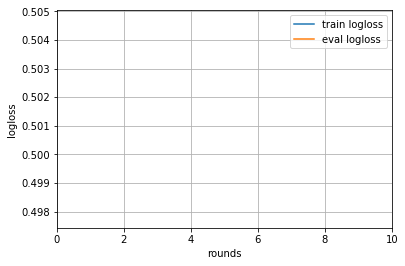

In [23]:
bst2 = train2(df)

In [15]:
bst = train(df)

0.8205607476635514
